# IMDB Movie Review Sentiment Analysis with TensorFlow

Binary sentiment classification on IMDB movie reviews with a CNN model in TensorFlow
* [2014 paper by Kim](https://arxiv.org/pdf/1408.5882v2.pdf)
* [WILDML blog post](http://www.wildml.com/2015/12/implementing-a-cnn-for-text-classification-in-tensorflow/)
* [TensorFlow documentation](https://www.tensorflow.org/api_docs/python/)
* [Large Movie Review Dataset](http://ai.stanford.edu/~amaas/data/sentiment/)

In [1]:
# Import packages
import os
import re
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from random import shuffle
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from tflearn.data_utils import VocabularyProcessor

# Define dataset directories
train_pos_dir = 'aclImdb/train/pos/'
train_neg_dir = 'aclImdb/train/neg/'
test_pos_dir = 'aclImdb/test/pos/'
test_neg_dir = 'aclImdb/test/neg/'

# Define dataset size
data_set_size = 12500

In [2]:
# Read data
train_pos = []
for file_name in os.listdir(train_pos_dir):
    with open(train_pos_dir + file_name, 'r') as myfile:
        train_pos.append(myfile.read())
        
train_neg = []
for file_name in os.listdir(train_neg_dir):
    with open(train_neg_dir + file_name, 'r') as myfile:
        train_neg.append(myfile.read())

test_pos = []
for file_name in os.listdir(test_pos_dir):
    with open(test_pos_dir + file_name, 'r') as myfile:
        test_pos.append(myfile.read())
        
test_neg = []
for file_name in os.listdir(test_neg_dir):
    with open(test_neg_dir + file_name, 'r') as myfile:
        test_neg.append(myfile.read())                 
        
# Cleanse data    
stop_words = set(stopwords.words("english"))

def parse_html(data):
    data = BeautifulSoup(data, 'lxml').get_text() # Remove markup
    data = re.sub("[^a-zA-Z]"," ", data) # Remove all non-alphanumeric characters
    data = ' '.join([x for x in data.lower().split() if not x in stop_words]) # Remove stopwords
    return data    
    
for i in xrange(data_set_size):
    train_pos[i] = parse_html(train_pos[i])
    train_neg[i] = parse_html(train_neg[i])
    test_pos[i] = parse_html(test_pos[i])
    test_neg[i] = parse_html(test_neg[i])    
    
train_x = np.concatenate([train_pos, train_neg])
train_y = np.concatenate([[[0, 1] for _ in xrange(data_set_size)], [[1, 0] for _ in xrange(data_set_size)]])
test_x = np.concatenate([test_pos, test_neg])
test_y = np.concatenate([[[0, 1] for _ in xrange(data_set_size)], [[1, 0] for _ in xrange(data_set_size)]])
total_x = np.concatenate([train_pos, train_neg, test_pos, test_neg])
    
print '%i train reviews:' % len(train_x)
print train_x[0][:100]
print '\n%i test reviews:' % len(test_x)
print test_x[0][:100]
print '\n%i total reviews:' % len(total_x)
print total_x[0][:100]

25000 train reviews:
anime underrated still hardly dorky kids movie noted still come back years first saw one better movi

25000 test reviews:
sure version film saw entertaining know twins gillian chung charlene choi seeing movie think english

50000 total reviews:
anime underrated still hardly dorky kids movie noted still come back years first saw one better movi


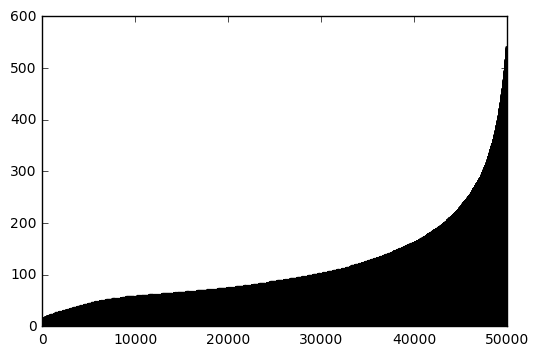

In [3]:
# Graph distribution of review lengths
%matplotlib inline
review_lengths = sorted([len(x.split()) for x in train_x] + [len(x.split()) for x in test_x])[:49900]
plt.show(plt.bar(range(len(review_lengths)), review_lengths))

In [5]:
# Convert reviews into padded word indexes
num_words = 250 # Based on graph (want to capture most reviews without too much padding)
vocab_processor = VocabularyProcessor(num_words).fit_transform(total_x)
total_x_vector = np.array(list(vocab_processor))
train_x_vector = total_x_vector[:25000]
test_x_vector = total_x_vector[25000:]

# Shuffle data
shuffled_i = np.random.permutation(np.arange(data_set_size * 2))
train_x_vector_shuffled = train_x_vector[shuffled_i]
train_y_shuffled = train_y[shuffled_i]
test_x_vector_shuffled = test_x_vector[shuffled_i]
test_y_shuffled = test_y[shuffled_i]

In [32]:
# Variables
epochs = 10
batch_size = 64
num_steps = int(data_set_size * 2 / batch_size * epochs)
reg_constant = 0.01
num_classes = 2
vocab_size = max([max(x) for x in total_x_vector]) + 1 # 101244
embedding_size = 128 
patch_size_1 = 3
patch_size_2 = 4
patch_size_3 = 5
num_channels = 1
conv_depth = 128
conv_stride = [1, 1, 1, 1]
pool_stride = [1, 1, 1, 1]
padding = 'VALID'
losses = []

# Graph
with tf.Graph().as_default():
    with tf.Session() as session:
        # Input data
        data_x_tf = tf.placeholder(tf.int32, [batch_size, num_words])
        data_y_tf = tf.placeholder(tf.float32, [batch_size, num_classes])
        dropout_tf = tf.placeholder(tf.float32)

        # Embeddeding
        embedding_space = tf.Variable(tf.random_uniform([vocab_size, embedding_size])) 
        data_x_embedded = tf.nn.embedding_lookup(embedding_space, data_x_tf) 
        data_x_embedded_expanded = tf.expand_dims(data_x_embedded, -1) 

        # Fist convolution
        conv_1_weights = tf.Variable(tf.truncated_normal([patch_size_1, embedding_size, num_channels, conv_depth]))
        conv_1_biases = tf.Variable(tf.constant(0.1, shape=(conv_depth,)))
        conv_1 = tf.nn.conv2d(data_x_embedded_expanded, conv_1_weights, conv_stride, padding)
        conv_1_relu = tf.nn.relu(tf.nn.bias_add(conv_1, conv_1_biases))
        pool_1 = tf.nn.max_pool(conv_1_relu, [1, num_words - patch_size_1 + 1, 1, 1], pool_stride, padding)

        # Second convolution
        conv_2_weights = tf.Variable(tf.truncated_normal([patch_size_2, embedding_size, num_channels, conv_depth]))
        conv_2_biases = tf.Variable(tf.constant(0.1, shape=(conv_depth,)))
        conv_2 = tf.nn.conv2d(data_x_embedded_expanded, conv_2_weights, conv_stride, padding)
        conv_2_relu = tf.nn.relu(tf.nn.bias_add(conv_2, conv_2_biases))
        pool_2 = tf.nn.max_pool(conv_2_relu, [1, num_words - patch_size_2 + 1, 1, 1], pool_stride, padding)

        # Third convolution
        conv_3_weights = tf.Variable(tf.truncated_normal([patch_size_3, embedding_size, num_channels, conv_depth]))
        conv_3_biases = tf.Variable(tf.constant(0.1, shape=(conv_depth,)))
        conv_3 = tf.nn.conv2d(data_x_embedded_expanded, conv_3_weights, conv_stride, padding)
        conv_3_relu = tf.nn.relu(tf.nn.bias_add(conv_3, conv_3_biases))
        pool_3 = tf.nn.max_pool(conv_3_relu, [1, num_words - patch_size_3 + 1, 1, 1], pool_stride, padding)

        # Reshape
        pool = tf.concat(3, [pool_1, pool_2, pool_3])
        pool_shape = pool.get_shape().as_list()
        reshaped_pool = tf.reshape(pool, [pool_shape[0],  pool_shape[3]])            
        reshaped_pool_dropout = tf.nn.dropout(reshaped_pool, dropout_tf)           

        # Output layer weights and biases
        output_weights = tf.Variable(tf.truncated_normal([conv_depth * 3, num_classes]))
        output_biases = tf.Variable(tf.constant(0.1, shape=(num_classes,)))                         
        output = tf.nn.bias_add(tf.matmul(reshaped_pool_dropout, output_weights), output_biases)

        # Loss, optimizer, and predictions
        regularization = reg_constant * tf.nn.l2_loss(output_weights)
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(output, data_y_tf) + regularization)
        loss_summary = tf.scalar_summary('loss', loss)
        optimizer = tf.train.AdamOptimizer().minimize(loss)
        preds = tf.nn.softmax(output)

        # Write accuracy to summary
        sim = tf.equal(tf.argmax(preds, 1), tf.argmax(data_y_tf, 1))
        accuracy = tf.reduce_mean(tf.cast(sim, tf.float32)) * 100
        accuracy_summary = tf.scalar_summary('accuracy', accuracy)           
        merged_train = tf.merge_summary([loss_summary, accuracy_summary])
        summary_writer_train = tf.train.SummaryWriter('tensorboard/train', session.graph)
 
        # Train model
        tf.initialize_all_variables().run()
        for i in xrange(num_steps):
            batch_start = batch_size * i % (data_set_size * 2 - batch_size)
            batch_end = batch_start + batch_size
            batch_x = train_x_vector_shuffled[batch_start:batch_end,:]
            batch_y = train_y_shuffled[batch_start:batch_end,:]            
            feed_dict = {data_x_tf: batch_x, data_y_tf: batch_y, dropout_tf: 0.5}   
            _, l, summary, accuracy_train = session.run([optimizer, loss, merged_train, accuracy], feed_dict) 
            summary_writer_train.add_summary(summary, i)            
            if i % int(num_steps / epochs) == 0:
                epoch_num = int(i / int(num_steps / epochs))
                print('Train epoch %d: loss = %.2f, train accuracy = %.2f%%' % (epoch_num, l, accuracy_train))

        # Test model
        test_preds_total = []
        for i in xrange(int(np.floor(data_set_size * 2 / batch_size))):
            batch_start = batch_size * i
            batch_end = batch_start + batch_size
            batch_x = test_x_vector_shuffled[batch_start:batch_end,:]
            batch_y = test_y_shuffled[batch_start:batch_end,:]
            feed_dict = {data_x_tf: batch_x, data_y_tf: batch_y, dropout_tf: 1.0}  
            test_preds_total += (session.run([accuracy], feed_dict))
        print 'Test set accuracy: %.2f%%' % (sum(test_preds_total) / len(test_preds_total))

Train epoch 0: loss = 165.88, train accuracy = 45.31%
Train epoch 1: loss = 27.66, train accuracy = 65.62%
Train epoch 2: loss = 7.41, train accuracy = 75.00%
Train epoch 3: loss = 6.32, train accuracy = 73.44%
Train epoch 4: loss = 4.36, train accuracy = 73.44%
Train epoch 5: loss = 3.18, train accuracy = 84.38%
Train epoch 6: loss = 3.01, train accuracy = 87.50%
Train epoch 7: loss = 2.98, train accuracy = 89.06%
Train epoch 8: loss = 2.71, train accuracy = 89.06%
Train epoch 9: loss = 2.32, train accuracy = 90.62%
Test set accuracy: 69.92%
